This notebook is meant to be an exploration tool for examining sequencing coverage and sequenct variants among sequence reads from metagenomic time series samples, aligned to isolate genomes

In [335]:
# imports

import os
import pybedtools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets

In [336]:
# set global variables

base_directory = '../scratchspace/test_output/'

In [337]:
# functions (move this to a .py file)

def coverage_variants_plot(coverage_bed, variant_bed, begin, end, axis, name=None, labels=True, legend=True):
    """
    coverage_variants_plot() returns an overlay plot with the coverage and variants within a given region.
        Note that the coverage bed and variant bed provided should both be for the same region.
        
    Args:
        coverage_bed (pybedtools.bedtool.BedTool): product of a bedtools intersect between a coverage BedTool, 
            and a region of interest
        variant_bed (pybedtools.bedtool.BedTool): product of a bedtools intersect between a variant (.vcf) BedTool, 
            and a region of interest
        begin (int): genome coordinate of start of region of interest
        end (int): genome coordinate of end of region of interest
        axis (matplotlib.axis.Axis): a matplotlib axis object, on which the resulting plot will be drawn
        name (str): default=None, if not none, this string will display as the title above the plot
        labels (bool): default=True, if True, axis labels will be added to the plot
        legend (bool): default=True, if True, a legend will be added to the plot
        
    Returns:
        a matplotlib axis object, with the read coverage and variants of an aligned region of interest plotted
    """
    coverage_bases = []
    coverage = []
    variant_bases = [0.0]
    p_variant = [0.0]

    for interval in coverage_bed:
        start = interval.start - begin + 0.1    # offset coordinates to convert to floats
        stop = interval.stop - begin - 0.1    # and to prevent two depths at the same coordinate
        depth = float(interval.name)
        coverage_bases.extend([start, stop])    # add both start and stop to the list of positions
        coverage.extend([depth, depth])    # add depths for both start and stop coordinates
    
    for interval in variant_bed:
        start = interval.start - begin + 0.1    # offset coordinates to convert to floats
        stop = interval.stop - begin - 0.1    # and to prevent two depths at the same coordinate
        p_value = 1.0 - math.pow(10.0, float(interval[5]) * -0.1)    # calculate p-value from Phred score
        variant_bases.extend([start - 0.1, start, stop, stop + 0.1])    # add both start and stop to the list of positions
        p_variant.extend([0.0, p_value, p_value, 0.0])    # add depths for both start and stop coordinates
    variant_bases.append(end - begin)
    p_variant.append(0.0)
    
    axis2 = axis.twinx()
    sns.lineplot(x=coverage_bases, y=coverage, ax=axis, color='blue', label='coverage', legend=False)    
    # plot coverage second, y axis on left
    sns.lineplot(x=variant_bases, y=p_variant, ax=axis2, color='orange', alpha=0.5, 
                            label='sequence\nvariants', legend=False)    
    # plot variants first, y axis on right
    axis.fill_between(x=coverage_bases, y1=coverage, color='blue', alpha=0.3)
    axis2.set_ylim([-0.05, 1.05])
    
    if name != None:
        axis.set_title(name)
    else:
        pass
    
    if labels:
        axis.set_xlabel('relative base coordinate')
        axis.set_ylabel('coverage depth\n(number of reads)')
        axis2.set_ylabel('probability of\nsequence variation')
    else:
        pass
    
    if legend:
        cov_line, cov_label = axis.get_legend_handles_labels()
        var_line, var_label = axis2.get_legend_handles_labels()
        axis.legend(cov_line + var_line, cov_label + var_label)
    else:
        pass
        
    return axis2

# general plot function

def generate_combined_plot(alignments_df, isolate, region_bed):
    """
    generate_combined_plot()
    
    Args:
        alignments_df (pandas.DataFrame): DataFrame of the data of interest. Must contain at least these fields:
            ['week', 'O2', 'replicate', 'filepath']
        isolate (str): human-readable name of isolate genome to be examined
        region_bed (pybedtools.BedTool): BedTool object of region of interest
        
    Returns:
        matplotlib plot object
        matplotlib axes object
    """
    num_entries = alignments_df.shape[0]
    fig, axes = plt.subplots(num_entries, 1, sharex=True, figsize=(16, num_entries * 2))
    # loop over and generate coverage/variant plot for each data of interest
    for index, row in alignments_df.iterrows():
        # only add legend on first figure in set
        if index == 0:
            legend = True
        else:
            legend = False
        # pull filepath from dataframe
        filepath = row['filepath']
        # make the coverage BedTool, and intersect with region of interest
        coverage_bed = pybedtools.BedTool(filepath + '.coverage.bed')
        region_coverage = coverage_bed.intersect(region_bed)
        # make the variant BedTool, and intersect with region of interest
        variant_bed = pybedtools.BedTool(filepath + '.vcf')
        region_variants = variant_bed.intersect(region_bed)
        # compose title with week, O2 level, and replicate information
        title = 'week {} - {} O2 - replicate {}'.format(row['week'], row['O2'], row['replicate'])
        coverage_variants_plot(region_coverage, region_variants, region_bed[0].start, region_bed[0].stop, 
                               axes[index], title, labels=False, legend=legend)
    # write global labels to figure
    fig.text(0.5, 0.99, '{} - {}'.format(isolate, region_bed[0].name), ha='center', va='center', fontsize='x-large')
    fig.text(0.5, 0.03, 'relative base coordinate', ha='center', va='center', fontsize='large')
    fig.text(0.09, 0.5, 'coverage depth', ha='center', va='center', rotation='vertical', fontsize='large')
    fig.text(0.94, 0.5, 'probability of\nsequence variation', ha='center', va='center', rotation='vertical', 
             fontsize='large')
    return fig, axes

# functions to capture user input

def isolate_input(isolate):
    """
    isolate_input() is a function that can be passed to an ipywidgets.interactive() instance, to allow user 
        input in defining which isolate reference genome to examine
    
    Args:
        isolate (str): human-readable isolate genome
        
    Returns:
        isolate string
    """
    return isolate

def base_coord_input(start, stop, label):
    """
    base_coord_input() is a function that can be passed to an ipywidgets.interactive() instance, to allow user 
        input in defining the genome coordinates of the region of interest
    
    Args:
        start (str): string input that can be cast as an int
        stop (str): string input that can be cast as an int
        label (str): human-readable isolate genome
        
    Returns:
        start, stop, & label
    """
    start = int(start)
    stop = int(stop)
    label = str(label)
    return start, stop, label

def week_input(week_4, week_5, week_6, week_7, week_8, week_9, week_10, week_11, week_12, week_13, week_14):
    """
    week_input() is a function that can be passed to an ipywidgets.interactive() instance, to allow user 
        input in defining the sampling weeks to examine
    
    Args:
        week_x (bool): each week argument is a bool, whereby True signifies inclusion, and False signifies exclusion
        
    Returns:
        list of ints of selected week numbers
    """
    arguments = locals()
    week_lookup = {'week_4':4, 'week_5':5, 'week_6':6, 'week_7':7, 'week_8':8, 
                   'week_9':9, 'week_10':10, 'week_11':11, 'week_12':12, 'week_13':13, 'week_14':14}
    selected_weeks = []
    for week, included in arguments.items():
        if included:
            week_num = week_lookup[week]
            selected_weeks.append(week_num)
        else:
            pass
    return selected_weeks

def replicate_input(replicate_1, replicate_2, replicate_3, replicate_4):
    """
    replicate_input() is a function that can be passed to an ipywidgets.interactive() instance, to allow user 
        input in defining the replicates from each sample week to examine
    
    Args:
        replicate_x (bool): each replicate argument is a bool, whereby True signifies inclusion, 
            and False signifies exclusion
        
    Returns:
        list of ints of selected replicate numbers
    """
    arguments = locals()
    replicate_lookup = {'replicate_1':1, 'replicate_2':2, 'replicate_3':3, 'replicate_4':4}
    selected_replicates = []
    for rep, included in arguments.items():
        if included:
            rep_num = replicate_lookup[rep]
            selected_replicates.append(rep_num)
        else:
            pass
    return selected_replicates

def o2_level_input(low, high):
    """
    o2_level_input() is a function that can be passed to an ipywidgets.interactive() instance, to allow user 
        input in defining the oxygen levels from each sample week to examine
    
    Args:
        low, high (bool): each oxygen level argument is a bool, whereby True signifies inclusion, 
            and False signifies exclusion
        
    Returns:
        list of strings of selected oxygen levels
    """
    arguments = locals()
    selected_o2 = []
    for o2_level, included in arguments.items():
        if included:
            selected_o2.append(o2_level)
        else:
            pass
    return selected_o2

# function to build bedfiles for data

def get_reference(isolate, start, stop, label):
    """
    get_reference() takes the human-readable input isolate genome, and looks up the isolate directory name
        (also the NCBI id), and generates a bedfile based on this reference genome and the region of interest
    
    Args:
        isolate (str): human-readable input isolate genome
        start (int): input start base coordinate of region of interest
        stop (int): input stop base coordinate of region of interest
        label (str): input human-readable name for region of interest
        
    Returns:
        string of the isolate directory name
        pybedtools.BedTools of the region of interest 
    """
    isolate_genome_df = pd.read_csv(base_directory + 'aligned_isolate_genomes.csv')
    index = isolate_genome_df.loc[isolate_genome_df['human_name'] == isolate].index[0]
    isolate_directory = isolate_genome_df.loc[index, 'directory']
    bed_string = '{} {} {} {}'.format(isolate_directory, start, stop, label)
    region_bed = pybedtools.BedTool(bed_string, from_string=True)
    return isolate_directory, region_bed

# function to select data based on user inputs

def select_data(weeks, replicates, o2_levels, isolate_dir):
    """
    select_data() take the user inputs regarding which alignments are to be examined, 
        and using the 'fastq_sample_lookup.csv' file, down-selects a pandas DataFrame that contains only
        the data of interest. This function also appends a 'filename' column to the DataFrame that contains
        the relative pathname of the data in that row
    
    Args:
        weeks (list of ints): list of user-input weeks to be examined
        replicates (list of ints): list of user-input replicates to be examined
        o2_levels (list of strings): ['low'], ['high'], or ['low', 'high'] user wants both included
        isolate_dir (str): directory name of isolate to be examined
        
    Returns:
        pandas.DataFrame of the selected alignments, based on user input
    """
    alignments_df = pd.read_csv(base_directory + 'fastq_sample_lookup.csv')
    selected_data_df = alignments_df.loc[alignments_df['week'].isin(weeks)]
    selected_data_df = selected_data_df.loc[selected_data_df['replicate'].isin(replicates)]
    selected_data_df = selected_data_df.loc[selected_data_df['O2'].isin(o2_levels)]
    filepath_list = []
    for _, row in selected_data_df.iterrows():
        sample_dir = row['fastq']
        filepath = '{}/{}/{}/{}_{}'.format(base_directory, isolate_dir, sample_dir, sample_dir, isolate_dir)
        filepath_list.append(filepath)
    selected_data_df['filepath'] = filepath_list
    selected_data_df = selected_data_df[['sample', 'date', 'origin_O2', 'O2', 'week', 'replicate', 'filepath']]
    selected_data_df = selected_data_df.reset_index(drop=True)
    return selected_data_df

# function to check that bedfiles of interest actually exist where we think they do

def check_bedfiles_exist(data_df):
    """
    check_bedfiles_exist() uses the os packages to verify that all of the bedfiles for the data of interest
        can in fact be found where the pathnames direct
        
    Args:
        data_df (pandas.DataFrame): DataFrame of data of interest. Must contain the 'filepath' field corresponding
            to the pathname of the data of interest in each row
        
    Raises:
        If not all data of interest can be found, a warning will be printed out listing the samples for which
            the bedfiles were not located where the pathname directed
    
    Returns:
        pandas.DataFrame downselected to contain only the rows of the data for which all bedfiles could be located
    """
    exists_bool_mask = []
    for file in data_df['filepath'].tolist():
        coverage_bedfile = os.path.isfile(file + '.coverage.bed')
        vcf_file = os.path.isfile(file + '.vcf')
        exists_bool_mask.append(coverage_bedfile & vcf_file)
    existant_data_df = data_df.loc[exists_bool_mask]
    if existant_data_df.shape != data_df.shape:
        print('The following alignment files could not be located:\n')
        print(data_df.loc[[not bool_value for bool_value in exists_bool_mask]])
    else:
        pass
    existant_data_df = existant_data_df.reset_index(drop=True)
    return existant_data_df   


In [338]:
# instantiate user input functions

isolate = ipywidgets.interactive(isolate_input, isolate=isolates['human_name'].tolist())
base_coords = ipywidgets.interactive(base_coord_input, start='0', stop='0', label='region name')
weeks = ipywidgets.interactive(week_input, week_4=True, week_5=True, week_6=True, week_7=True, week_8=True, 
                               week_9=True, week_10=True, week_11=True, week_12=True, week_13=True, week_14=True)
replicates = ipywidgets.interactive(replicate_input, replicate_1=True, replicate_2=True, replicate_3=True, 
                                    replicate_4=True)
o2_levels = ipywidgets.interactive(o2_level_input, low=True, high=True)

# display user input interface

print('Please select isolate alignment')
display(isolate)
print('Please select base coordinates')
display(base_coords)
print('Please select sampling week(s)')
display(weeks)
print('Please select replicate(s)')
display(replicates)
print('Please select oxygen level(s)')
display(o2_levels)

Please select isolate alignment


interactive(children=(Dropdown(description='isolate', options=('Methylotenera mobilis JLW8', 'Methylomonas sp.…

Please select base coordinates


interactive(children=(Text(value='0', description='start'), Text(value='0', description='stop'), Text(value='r…

Please select sampling week(s)


interactive(children=(Checkbox(value=True, description='week_4'), Checkbox(value=True, description='week_5'), …

Please select replicate(s)


interactive(children=(Checkbox(value=True, description='replicate_1'), Checkbox(value=True, description='repli…

Please select oxygen level(s)


interactive(children=(Checkbox(value=True, description='low'), Checkbox(value=True, description='high'), Outpu…

In [339]:
# parse user inputs, process, and check necessary bedfiles exist
start, stop, name = base_coords.result
isolate_dir, region_of_interest_bed = get_reference(isolate.result, start, stop, name)

data_df = select_data(weeks.result, replicates.result, o2_levels.result, isolate_dir)
existant_data_df = check_bedfiles_exist(data_df)


/Users/stephenblaskowski/miniconda3/envs/seqalyze/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


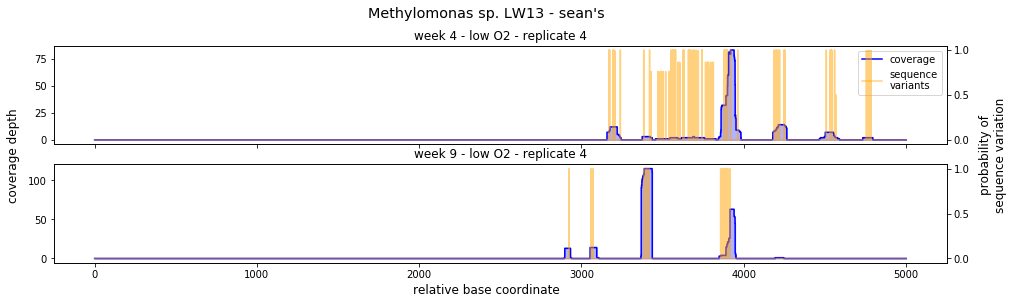

In [340]:
# plot region of interest

fig, axes = generate_combined_plot(existant_data_df, isolate.result, region_of_interest_bed)